In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from random import shuffle, randint, sample
import scipy.io as sio
from time import time
from IPython.display import Image
import os
import tensorflow as tf
from tensorflow import keras
import PIL
import cv2
from PIL import Image
import script as ut
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Fix seeds of random generators to make this notebook's output stable across runs
np.random.seed(126)
tf.random.set_seed(126)
# random.seed(126)

# Check available CPUs and GPUs
# import multiprocessing
# print("Number of CPUs Available: ", multiprocessing.cpu_count())
# print("Number of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Visualization
#import napari
# %gui qt5

# Where to save figures
# PROJECT_ROOT_DIR = "."
# CHAPTER_ID = "cnn"
# IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
# os.makedirs(IMAGES_PATH, exist_ok=True)

# def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
#     path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
#     print("Saving figure", fig_id)
#     if tight_layout:
#         plt.tight_layout()
#     plt.savefig(path, format=fig_extension, dpi=resolution)

Number of CPUs Available:  20
Number of GPUs Available:  1
Default GPU Device: /device:GPU:0


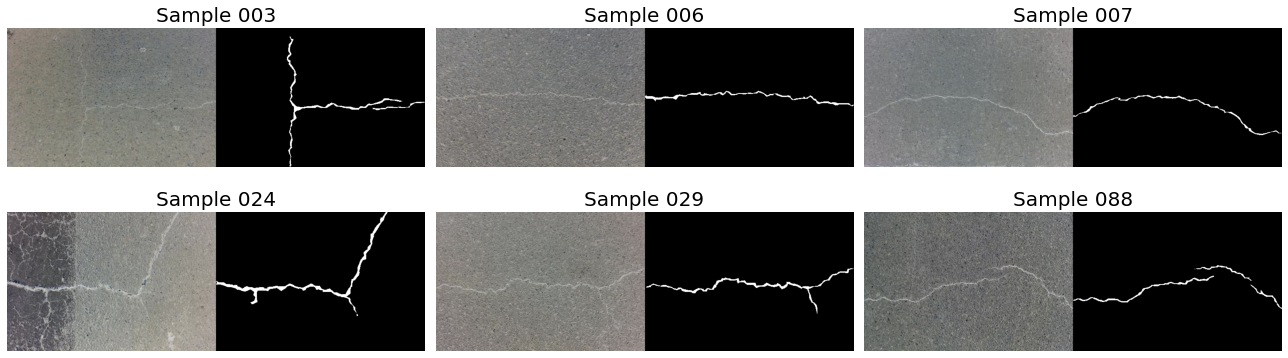

In [2]:
axes = []
valor_imagenes = 0
new_df = pd.DataFrame()

basepath = Path('../../datasets/TFG')
label_path = basepath / "ground"
image_path = basepath / "original"
for i in range(1):
  # indices of samples to be excluded
  removed_id = np.array([3, 6, 7, 24, 29, 88])-1
  label_files = os.listdir(label_path)
  label_files_removed = [label_files[i] for i in removed_id]
  #print(label_files_removed)

  fig = plt.figure(figsize=(18, 8))
  for i, label_file in enumerate(label_files_removed):
      image_file = label_file.split('.')[0] + '.tif'  # image file name
      img = mpimg.imread(os.path.join(image_path, image_file)) / 255

      seg_mask = ut.read_image(label_path / label_file) / 255
      # seg_mask[seg_mask == 1] = 0 #In case it is not 1,0 binary
      # seg_mask[seg_mask > 1] = 1

      label_temp = np.zeros_like(img, dtype='int32')
      for j in range(3):
          label_temp[:, :, j] = seg_mask
      img_label = np.hstack([img, label_temp])

      ax = fig.add_subplot(3, 3, i+1)
      ax.imshow(img_label, vmin=0, vmax=1)
      ax.axis('off')
      ax.set_title('Sample {}'.format(label_file.split('.')[0]), fontsize=20)
  plt.tight_layout()


In [3]:

  # Indices of remaining samples in the data set
  all_id = np.arange(99) # indices of all samples
  remained_id = np.setdiff1d(all_id, removed_id) # indices of remaining samples in the data set
  #print(f'number of remaining samples: {len(remained_id)}\n indices: {remained_id}')


In [4]:

n_train = 20  # number of training samples
n_test = 5  # number of testing samples

train_id = np.array(sample(remained_id.tolist(), n_train)
                    )  # random samples for training
remained_id2 = np.setdiff1d(remained_id, train_id)

test_id = np.array(sample(remained_id2.tolist(), n_test)
                   )   # random samples for testing
remained_id2 = np.setdiff1d(remained_id2, test_id)

#print(f"Number of Training samples: {train_id.size}")
#print("  Indices: ", train_id+1)
#print(f"Number of Testing samples: {test_id.size}")
#print("  Indices: ", test_id+1)

h = 13  # input patch size: [2h+1, 2h+1]
s = 5    # output patch size: [2s+1, 2s+1] aqui va un 2
#ratio = 3.0 # ratio of the number of negative samples to the number of positive samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


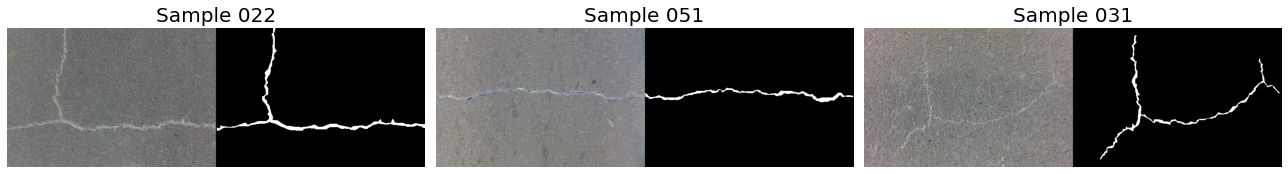

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


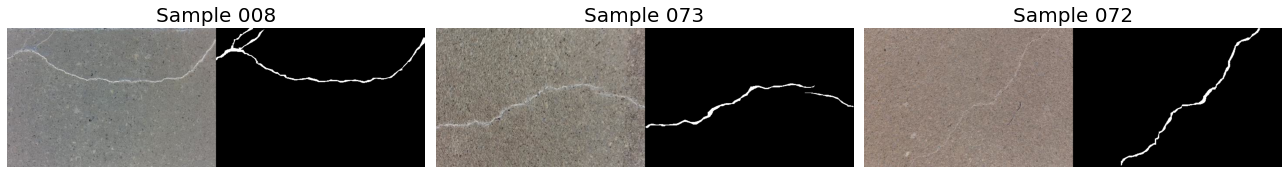

In [5]:

  # Visualize images and ground truth in the Training set and the Testing set
  # Defined above basepath
  label_path = basepath / "ground" # the path to the ground truth folder groundprueba
  image_path = basepath / "original" # the path to the image folder tff


 # print('Training samples:')
  ut.plot_samples(image_path, label_path, train_id[-3:])

  #print('Testing samples:')
  tst = ut.plot_samples(image_path, label_path, test_id[-3:])

  # Set Hyperparameters and Paths
  ## Optimizer not defined. It says 'adam' and it is probably using the default.
  optimizer = 'adam'
  lr = 1e-3        # learning rate
  epoch = 30    # number of training epochs 10 el normal 
  # batch size y 128 el valor normal 
  folder_name = f'ntrain{n_train}_ntest{n_test}_Sout{2*s+1}'
  savedir = basepath / 'seg_conv' / 'results' / folder_name # directory for saving the trained model and outputs
  os.makedirs(savedir, exist_ok=True)


In [6]:
X_train, y_train = ut.load_data(
    image_path, label_path, train_id, flag_shuffle=True, ratio=3.0, h=h, s=s)
X_test, y_test = ut.load_data(image_path, label_path, test_id,
                              flag_shuffle=False, ratio=45.0, h=h, s=s)  # Con 45 funciona
X_train /= 255.0  # scale pixel intensity to [0,1]
X_test /= 255.0  # scale pixel intensity to [0,1]
#print(f'Training set: input shape: {X_train.shape}, output shape: {y_train.shape}')
#print(f'testing set: input shape: {X_test.shape}, output shape: {y_test.shape}')
# Instantiate and Compile a CNN model


In [7]:
batch_size = 64

In [8]:
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    samplewise_center=False,
    featurewise_std_normalization=True,
    samplewise_std_normalization=False, 
    validation_split=0.2
)

train_datagen.fit(X_train)

train_generator = train_datagen.flow(X_train, y_train,batch_size = batch_size,subset='training',shuffle=True,seed=42)

validation_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, subset='validation', shuffle=True, seed=42)


In [10]:
import time

cnn = ut.model(h=h, s=s)
cnn.compile(optimizer=optimizer, loss='binary_crossentropy',
            metrics=['binary_accuracy'])

# Train CNN; Use 20% training data as a validation set
start = time.time()
history = cnn.fit(train_generator, epochs=epoch, validation_data = validation_generator)
end = time.time()
# time0 = time()
# print(f'training time: {(time()-time0)/60:.2f} mins')
#print('Time: ',end - start)


Epoch 1/30
4188/4188 [==============================] - 21s 5ms/step - loss: 0.3634 - binary_accuracy: 0.8316 - val_loss: 0.3472 - val_binary_accuracy: 0.7939
Epoch 2/30
4188/4188 [==============================] - 21s 5ms/step - loss: 0.2550 - binary_accuracy: 0.8941 - val_loss: 0.3207 - val_binary_accuracy: 0.8335
Epoch 3/30
4188/4188 [==============================] - 21s 5ms/step - loss: 0.2090 - binary_accuracy: 0.9187 - val_loss: 0.2633 - val_binary_accuracy: 0.8793
Epoch 4/30
4188/4188 [==============================] - 21s 5ms/step - loss: 0.1881 - binary_accuracy: 0.9271 - val_loss: 0.3086 - val_binary_accuracy: 0.8531
Epoch 5/30
4188/4188 [==============================] - 21s 5ms/step - loss: 0.1756 - binary_accuracy: 0.9324 - val_loss: 0.2234 - val_binary_accuracy: 0.9033
Epoch 6/30
4188/4188 [==============================] - 21s 5ms/step - loss: 0.1701 - binary_accuracy: 0.9348 - val_loss: 0.2695 - val_binary_accuracy: 0.8715
Epoch 7/30
4188/4188 [========================

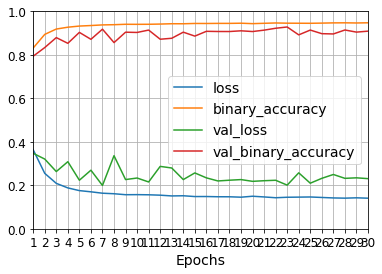

In [11]:
fig = plt.figure(figsize=(6, 4))
for i in history.history.keys():
      plt.plot(np.arange(1, epoch+1), history.history[i], label=i)
plt.grid()
plt.xlim(1, epoch)
plt.ylim(0, 1)
plt.xlabel('Epochs')
plt.xticks(np.arange(1, epoch+1))
plt.legend(fontsize=14)
valor_imagenes += 1
a = valor_imagenes
#plt.savefig("/../../datasets/TFG/figs/learning_curves%a.png" % a)
plt.show()




In [12]:
test_datagen = ImageDataGenerator(
    featurewise_center=True,
    samplewise_center=False,
    featurewise_std_normalization=True,
    samplewise_std_normalization=False,
)


test_datagen.fit(X_train)

train_generator = test_datagen.flow(
    X_test, y_test, batch_size=batch_size, shuffle=True, seed=42)


In [13]:

  # Evaluate the trained model on the Testing set
  test_eval = cnn.evaluate(train_generator)
  print("\n Test loss: {:.8f}    Test accuracy: {:.8f}".format(test_eval[0], test_eval[1]))

  # Crack prediction on last 3 samples in the Training set by the trained model
  fig_path = savedir / 'pred_train'
  os.makedirs(fig_path, exist_ok=True)
  


7345/7345 [==============================] - 18s 2ms/step - loss: 0.1068 - binary_accuracy: 0.9609

 Test loss: 0.10684244    Test accuracy: 0.96088892


Training samples:
hereeeeeeeeeeee
here1
here2
here3
here5
here6
here7


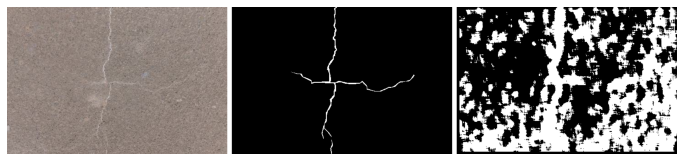

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x0000015B46F84AF8>
Traceback (most recent call last):
  File "C:\Users\goofy\anaconda3\envs\d2l\lib\weakref.py", line 359, in remove
    self = selfref()
KeyboardInterrupt


In [14]:
  print('Training samples:')
  precision, recal, f1, prob_maps = ut.crack_pred(cnn, label_path, image_path, fig_path, train_id[:24], h=h, s=s, prob=0.5) #prob 0.5 default

  print("Average Training Precision: {:0.8f}".format(precision))
  print("Average Training Recall:    {:0.8f}".format(recal))
  print("Average Training F1:        {:0.8f}".format(f1))
  

  # Crack prediction on Testing set by the trained model
  # fig_path = os.path.join(savedir, 'pred_test')
  # os.makedirs(fig_path, exist_ok=True)
  print('Testing samples:')
  precision_test, recall_test, f1_test, prob = ut.crack_pred(cnn, label_path, image_path, fig_path, test_id[:5], h=h, s=s, prob=0.5)

  print("Average Testing Precision: {:0.8f}".format(precision_test))
  print("Average Testing Recall:    {:0.8f}".format(recall_test))
  print("Average Testing F1:        {:0.8f}".format(f1_test))

  df_score = pd.DataFrame([[train_id.size, test_id.size, h, s, precision_test, recall_test, f1_test]], index = [1], 
                          columns = ['n_train', 'n_test', 'h', 's', 'test_Precision', 'test', 'test_F1'])
  #df_score.head()
  new_df = new_df.append(df_score, ignore_index = True)
new_df.head()


